In [1]:
#SparkContext.setSystemProperty('spark.executor.pyspark.memory', '8g')
#from pyspark import SparkFiles
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

In [3]:
# read the csv which is stored in AWS s3 bucket
df = pd.read_csv("https://icdrive1.s3.amazonaws.com/drug_review_data_cleaned.csv",sep=",")
df.head()

,Unnamed: 0,_c0,uniqueID,drugName,condition,review,rating,usefulCount,review_date,review_outcome,pos,neg,label
0,0,0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,27,2012-05-20,Positive,0.000,0.136,1
1,1,1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,192,2010-04-27,Positive,0.111,0.018,1
2,2,2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,17,2009-12-14,Negative,0.083,0.062,0
3,3,3,138000,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,10,2015-11-03,Positive,0.093,0.027,1
4,4,4,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,37,2016-11-27,Positive,0.178,0.064,1


In [4]:
#creating new dataframe with just review and rating column
df2 = df[['uniqueID','review','rating']]
df2.head()

,uniqueID,review,rating
0,206461,"It has no side effect, I take it in combinatio...",9
1,95260,My son is halfway through his fourth week of I...,8
2,92703,"I used to take another oral contraceptive, whi...",5
3,138000,This is my first time using any form of birth ...,8
4,35696,Suboxone has completely turned my life around....,9


In [5]:
#checking for null value
df2.isnull().any().any()

False

In [6]:
# downloading punkt and stopwords from nltk
import nltk
nltk.download(['punkt','stopwords'])

[nltk_data] Downloading package punkt to /Users/nilamroy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nilamroy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#importing stopwords from nltk 
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [8]:
#showing the dataframe 
df2.head()

,uniqueID,review,rating
0,206461,"It has no side effect, I take it in combinatio...",9
1,95260,My son is halfway through his fourth week of I...,8
2,92703,"I used to take another oral contraceptive, whi...",5
3,138000,This is my first time using any form of birth ...,8
4,35696,Suboxone has completely turned my life around....,9


In [9]:
#Vader library is used for sentiment analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [10]:
#Assigning a score based on analyzing the review column
df2['vaderReviewScore']=df2['review'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

/Users/nilamroy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
#showing the dataframe
df2.head()

,uniqueID,review,rating,vaderReviewScore
0,206461,"It has no side effect, I take it in combinatio...",9,-0.2960
1,95260,My son is halfway through his fourth week of I...,8,0.9174
2,92703,"I used to take another oral contraceptive, whi...",5,0.6160
3,138000,This is my first time using any form of birth ...,8,0.7184
4,35696,Suboxone has completely turned my life around....,9,0.9403


In [12]:
#positive and negative score is assigning based on vaderreview score
pos_num = len(df2[df2['vaderReviewScore'] >=0.05])
neg_num = len(df2[df2['vaderReviewScore'] <= 0.05])

In [13]:
#displaying the total number of positive and negative category
pos_num,neg_num

(100167, 114898)

In [14]:
#converitng into 1 or 0 label
df2['vaderSentiment']=df2['vaderReviewScore'].map(lambda x:int(1) if x>=0.05 else int(0))

/Users/nilamroy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
# displaying each count
df2['vaderSentiment'].value_counts()

0    114896
1    100167
Name: vaderSentiment, dtype: int64

In [17]:
#based on review score divide into positive and negative sentiment
df2.loc[df2['vaderReviewScore'] >= 0.05,"vadersentimentlabel"] = "positive"
df2.loc[df2['vaderReviewScore'] <= 0.05,"vadersentimentlabel"] = "negative"

In [18]:
#displaying dataframe with vader score and label
df2.head()

,uniqueID,review,rating,vaderReviewScore,vaderSentiment,vadersentimentlabel
0,206461,"It has no side effect, I take it in combinatio...",9,-0.2960,0,negative
1,95260,My son is halfway through his fourth week of I...,8,0.9174,1,positive
2,92703,"I used to take another oral contraceptive, whi...",5,0.6160,1,positive
3,138000,This is my first time using any form of birth ...,8,0.7184,1,positive
4,35696,Suboxone has completely turned my life around....,9,0.9403,1,positive


In [19]:
# rating based on rating column
pos_rating = len(df2[df2['rating'] >= 5])
neg_rating = len(df2[df2['rating'] <= 5])

In [20]:
#number of each column
pos_rating,neg_rating

(161491, 64295)

In [21]:
#if rating is more that 5 consider it as label 1 else 0
df2['ratingsentiment']=df2['rating'].map(lambda x:int(1) if x>=5 else int(0))

/Users/nilamroy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
#displaying each rating catagory
df2['ratingsentiment'].value_counts()

1    161491
0     53572
Name: ratingsentiment, dtype: int64

In [23]:
#assigning positive and negative rating based on start rating
df2.loc[df2['rating'] >= 5,"ratingsentimentlabel"] = "positive"
df2.loc[df2['rating'] <= 5,"ratingsentimentlabel"] = "negative"

In [24]:
#dispalying the dataframe with review ,rating and with both label
df2.head()

,uniqueID,review,rating,vaderReviewScore,vaderSentiment,vadersentimentlabel,ratingsentiment,ratingsentimentlabel
0,206461,"It has no side effect, I take it in combinatio...",9,-0.2960,0,negative,1,positive
1,95260,My son is halfway through his fourth week of I...,8,0.9174,1,positive,1,positive
2,92703,"I used to take another oral contraceptive, whi...",5,0.6160,1,positive,1,negative
3,138000,This is my first time using any form of birth ...,8,0.7184,1,positive,1,positive
4,35696,Suboxone has completely turned my life around....,9,0.9403,1,positive,1,positive


In [25]:
df2.groupby('ratingsentiment').size()

ratingsentiment
0     53572
1    161491
dtype: int64

In [26]:
#calculating positive review based on positive rating label
positive_vader_sentiment = df2[df2.ratingsentiment == 1]
positive_string =[]
for s in positive_vader_sentiment.review:
    positive_string.append(s)
positive_string = pd.Series(positive_string).str.cat(sep='')

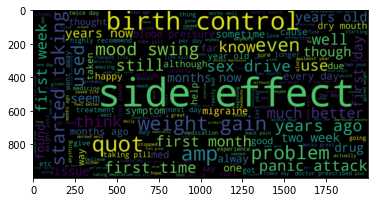

In [56]:
#ploting word frequency for positive sentiment
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=2000,height=1000).generate(positive_string)
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()

In [28]:
for s in positive_vader_sentiment.review[:10]:
    if 'side effect' in s:
        print(s)

It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil
I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it's the end of the third week- I still have daily brown discharge.
The positive side is that I didn't have any other side effects. The idea of being period free was so tempting... Alas.
Abilify changed my life. There is hope. I was on Zoloft and Clonidine when I first started Abilify at the age of 15.. Zoloft for depression and Clondine to manage my complete rage

In [29]:
#calculating negative review based on negative rating label
negative_vader_sentiment = df2[df2.ratingsentiment == 0]
negative_string =[]
for s in negative_vader_sentiment.review:
    negative_string.append(s)
negative_string = pd.Series(negative_string).str.cat(sep='')

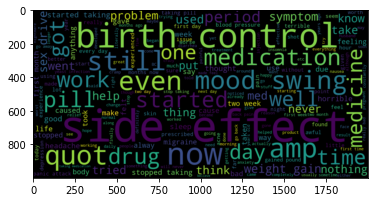

In [30]:
#ploting word frequency for negative sentiment
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=2000,height=1000).generate(negative_string)
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()

In [31]:
#importing Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
#calculating inverse TF based on review column
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1,4))
features = tfidf.fit_transform(df2.review)
labels = df2.vaderSentiment

In [35]:
#total column of feature variable
features.shape

(215063, 9619409)

In [36]:
#importing machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [37]:
#spliting feature and label variable in to train and test catagory
x_train,x_test,y_train,y_test = train_test_split(df2['review'],df2['ratingsentimentlabel'],random_state=0)

In [38]:
#importing different type of classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [39]:
#creating model based on Random Forest,linearSVC,Naive Bayes,LogisticRegresssion Regression 
models = [RandomForestClassifier(n_estimators=200,max_depth=3,random_state=0),LinearSVC(),MultinomialNB(),LogisticRegression(random_state=0,solver='lbfgs',max_iter=2000,multi_class='auto')]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model,features,labels,scoring='accuracy',cv=CV)
  for fold_idx,accuracy in enumerate(accuracies):
    entries.append((model_name,fold_idx,accuracy))
cv_df = pd.DataFrame(entries,columns=['model_name','fold_idx','accuracy'])

In [40]:
#displaying accuracy for each model for 5 fold iteration 
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.534245
1,RandomForestClassifier,1,0.534234
2,RandomForestClassifier,2,0.534246
3,RandomForestClassifier,3,0.534246
4,RandomForestClassifier,4,0.534246
5,LinearSVC,0,0.936997
6,LinearSVC,1,0.935926
7,LinearSVC,2,0.938227
8,LinearSVC,3,0.938552
9,LinearSVC,4,0.937297


In [41]:
#showing based model accuracy
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.937400
LogisticRegression        0.885931
MultinomialNB             0.879421
RandomForestClassifier    0.534243
Name: accuracy, dtype: float64

In [42]:
#importing normalizer for predicting input
from sklearn.preprocessing import Normalizer

In [43]:
#as SVC is proven for best model based on accuracy will run prediction based on that
model = LinearSVC('l2') #SVM with the square sum of slack variable are called L2-SVM
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.25,random_state=0)
normalize = Normalizer()
x_train = normalize.fit_transform(x_train)
x_test = normalize.transform(x_test)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [44]:
#accuracy for predicting output is more than 93%
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.9317226500018599


In [45]:
#creating confusion matrix for test and predicted output
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[27228,  1553],
       [ 2118, 22867]])

In [46]:
#imporing MLxtend library for ploting confusion matrix
from mlxtend.plotting import plot_confusion_matrix

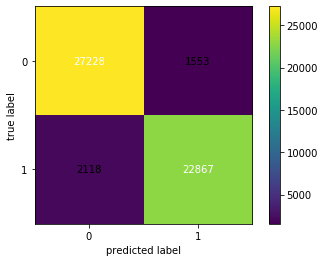

In [47]:
#displaying confusion matrix
fig,ax = plot_confusion_matrix(conf_mat=conf_mat,colorbar=True,show_absolute=True,cmap='viridis')

In [48]:
#summary table of SVC model
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=df2['ratingsentimentlabel'].unique()))

              precision    recall  f1-score   support

    positive       0.93      0.95      0.94     28781
    negative       0.94      0.92      0.93     24985

    accuracy                           0.93     53766
   macro avg       0.93      0.93      0.93     53766
weighted avg       0.93      0.93      0.93     53766



In [49]:
df2.vaderSentiment.unique()

array([0, 1])

In [51]:
df2.vadersentimentlabel.unique()

array(['negative', 'positive'], dtype=object)

In [52]:
#testing the model feeding unknown review
print(model.predict(tfidf.transform(["This drug is the best so far after trying so many other grugs which gave terrible side effect"])))

[1]


Model prediction is 1,which is positive sentiment label.So it is predicting properly.

In [54]:
print(model.predict(tfidf.transform(["This drug is horrible"])))

[0]


Model prediction is 0,which is negative sentiment label.So it is predicting properly.

In [55]:
print(model.predict(tfidf.transform(["lot of side effects"])))

[0]


Model prediction is 0,which is negative sentiment label.So it is predicting properly.